This is my enhanced codealong to https://keras.io/examples/nlp/lstm_seq2seq/ using my local Anaconda setup

Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import sys
sys.version

'3.7.10 (default, Feb 26 2021, 10:16:00) \n[Clang 10.0.0 ]'

In [3]:
np.__version__, tf.__version__, keras.__version__

('1.18.5', '2.5.0', '2.5.0')

Download the data

In [4]:
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

['Archive:  fra-eng.zip',
 'replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)',
 '  inflating: fra.txt                 ']

Configuration

In [4]:
batch_size = 64  # Batch size for training
epochs = 100  # Number of epochs to train for
latent_dim = 256  # Latent dimensionality of the encoding space
num_samples = 10000  # Number of samples to train on
# Path to the data txt file on disk
data_path = "fra.txt"

Prepare the data

In [5]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        input_characters.add(char)
    for char in target_text:
        target_characters.add(char)

In [6]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [7]:
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [8]:
print(input_characters)

[' ', '!', '"', '$', '%', '&', "'", ',', '-', '.', '0', '1', '2', '3', '5', '7', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'é']


In [9]:
print(target_characters)

['\t', '\n', ' ', '!', '$', '%', '&', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '5', '8', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '«', '»', 'À', 'Ç', 'É', 'Ê', 'à', 'â', 'ç', 'è', 'é', 'ê', 'î', 'ï', 'ô', 'ù', 'û', 'œ', '\u2009', '’', '\u202f']


In [10]:
for i in range(len(input_texts)):
    if len(target_texts[i]) == 59:
        print(input_texts[i], target_texts[i])

I got carded. 	On m'a demandé ma carte d'identité pour vérifier mon âge.



In [11]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)

decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [12]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Build the model

In [13]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

In [14]:
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [15]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

In [16]:
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [17]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm[0][1]                   

Train the model

In [19]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

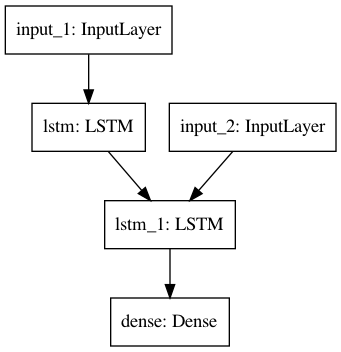

In [20]:
keras.utils.plot_model(model)

In [21]:
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2
)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
125/125 [==============================] - ETA: 0s - loss: 1.1482 - accuracy: 0.7346WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fa967d97b00> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

Epoch 44/100
125/125 [==============================] - 19s 156ms/step - loss: 0.1316 - accuracy: 0.9595 - val_loss: 0.5255 - val_accuracy: 0.8742
Epoch 45/100
125/125 [==============================] - 20s 157ms/step - loss: 0.1282 - accuracy: 0.9604 - val_loss: 0.5339 - val_accuracy: 0.8746
Epoch 46/100
125/125 [==============================] - 20s 157ms/step - loss: 0.1248 - accuracy: 0.9614 - val_loss: 0.5323 - val_accuracy: 0.8748
Epoch 47/100
125/125 [==============================] - 20s 162ms/step - loss: 0.1208 - accuracy: 0.9625 - val_loss: 0.5404 - val_accuracy: 0.8740
Epoch 48/100
125/125 [==============================] - 20s 163ms/step - loss: 0.1185 - accuracy: 0.9632 - val_loss: 0.5416 - val_accuracy: 0.8738
Epoch 49/100
125/125 [==============================] - 20s 163ms/step - loss: 0.1159 - accuracy: 0.9639 - val_loss: 0.5495 - val_accuracy: 0.8737
Epoch 50/100
125/125 [==============================] - 21s 165ms/step - loss: 0.1123 - accuracy: 0.9652 - val_loss: 0

Epoch 100/100
125/125 [==============================] - 21s 172ms/step - loss: 0.0444 - accuracy: 0.9843 - val_loss: 0.7684 - val_accuracy: 0.8691


In [22]:
# Save model
model.save("s2s_100epochs.h5")

In [23]:
model = keras.models.load_model("s2s_100epochs.h5")

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 335872      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  358400      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [25]:
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="decoder_state_input_h")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="decoder_state_input_c")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [26]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [27]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [28]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

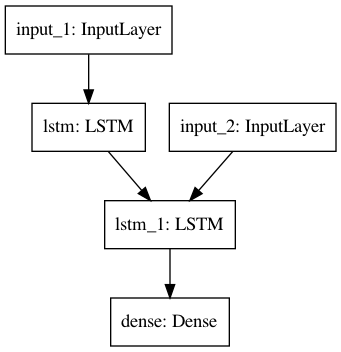

In [29]:
keras.utils.plot_model(model)

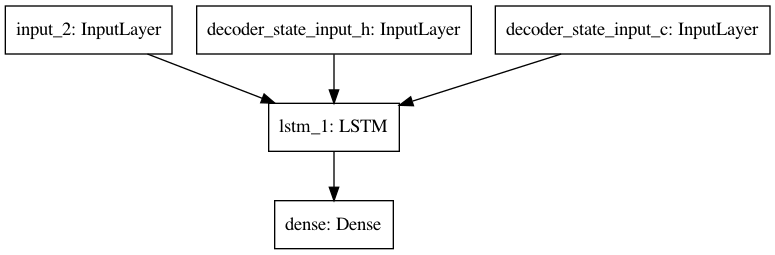

In [30]:
keras.utils.plot_model(decoder_model)

In [31]:
max_encoder_seq_length

15

In [32]:
def encode_and_call(input_text):
    encoder_input_data = np.zeros(
        (1, max_encoder_seq_length, num_encoder_tokens), dtype="float32"
    )
    for t, char in enumerate(input_text):
        encoder_input_data[0, t, input_token_index[char]] = 1.0
    encoder_input_data[0, t + 1 :, input_token_index[" "]] = 1.0

    decoded_sentence = decode_sequence(encoder_input_data)
    print("-")
    print("Input sentence:", input_text)
    print("Decoded sentence:", decoded_sentence)

In [33]:
encode_and_call("Hi!")

-
Input sentence: Hi!
Decoded sentence: Étaigera !



In [34]:
encode_and_call("How are you?")

-
Input sentence: How are you?
Decoded sentence: Comment ça va ?



In [35]:
encode_and_call("Go!")

encode_and_call("Hi.")

encode_and_call("I go to school.")

encode_and_call("School.")

encode_and_call("Run.")

encode_and_call("Go.")

encode_and_call("March.")

encode_and_call("This is good.")

encode_and_call("Sky is blue.")

encode_and_call("blue")

encode_and_call("sky")

encode_and_call("Go to school.")

encode_and_call("I Go to school.")

encode_and_call("I hate school.")

encode_and_call("I quit smoking.")

encode_and_call("Does it work?")

encode_and_call("Does it hurt?")

encode_and_call("It hurts.")

encode_and_call("I'm weak.")

encode_and_call("Tom is weak.")

-
Input sentence: Go!
Decoded sentence: Fouve !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: I go to school.
Decoded sentence: Je vais travailler.

-
Input sentence: School.
Decoded sentence: Chaitone ceurez !

-
Input sentence: Run.
Decoded sentence: Cours !

-
Input sentence: Go.
Decoded sentence: Bouge !

-
Input sentence: March.
Decoded sentence: Calme-toi.

-
Input sentence: This is good.
Decoded sentence: C'est la vie.

-
Input sentence: Sky is blue.
Decoded sentence: Crouge !

-
Input sentence: blue
Decoded sentence: Je l'ai ampré.

-
Input sentence: sky
Decoded sentence: Time-tous !

-
Input sentence: Go to school.
Decoded sentence: Va à l'écile.

-
Input sentence: I Go to school.
Decoded sentence: Je ne perdrai pas.

-
Input sentence: I hate school.
Decoded sentence: Je déteste le café.

-
Input sentence: I quit smoking.
Decoded sentence: J'arrête a meigne.

-
Input sentence: Does it work?
Decoded sentence: Est-ce que ça fonctionne ?

-
Input sentence: D